In [1]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 41.9 MB/s eta 0:00:00


In [2]:
!python -m spacy download en_core_web_sm

2023-01-13 05:14:48.197820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 05:14:48.362735: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-13 05:14:49.162873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-13 05:14:49.163824: W tensorflow/compiler/xla/stream_executor

In [3]:
import pathlib 
import warnings
import os
import io
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

import tensorflow_text
import tensorflow as tf 
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

In [4]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.4 MB/s eta 0:00:00


Scammers send fake text messages to trick you into giving them your personal information – things like your password, account number, or Social Security number. If they get that information, they could gain access to your email, bank, or other accounts.

Spam Detection is a binary classification problem. The reason to do this is simple: by detecting unsolicited and unwanted messages, we can prevent spam messages from creeping into the user's inbox, thereby improving user experience.

In [5]:
df = pd.read_csv('./spam.csv', encoding='ISO-8859-1')
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [6]:
df.groupby('v1').describe()

v2                                                                 \
     count unique                                                top freq   
v1                                                                          
ham   4825   4516                             Sorry, I'll call later   30   
spam   747    653  Please call our customer service representativ...    4   

     Unnamed: 2                                                            \
          count unique                                                top   
v1                                                                          
ham          45     39   bt not his girlfrnd... G o o d n i g h t . . .@"   
spam          5      4                                        PO Box 5249   

          Unnamed: 3                                    Unnamed: 4         \
     freq      count unique                    top freq      count unique   
v1                                                                          
ham     3         10      9                     GE    2          6      5   
spam    2          2      1   MK17 92H. 450Ppw 16"    2          0      0   

                    
          top freq  
v1                  
ham   GNT:-)"    2  
spam      NaN  NaN

In [7]:
df['length']=df['v2'].apply(len)
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,length
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61


Let's drop those three unnamed columns as they won't bring much to our model building anyways.

In [8]:
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
df = df.rename(columns={'v1':'label','v2':'message'})

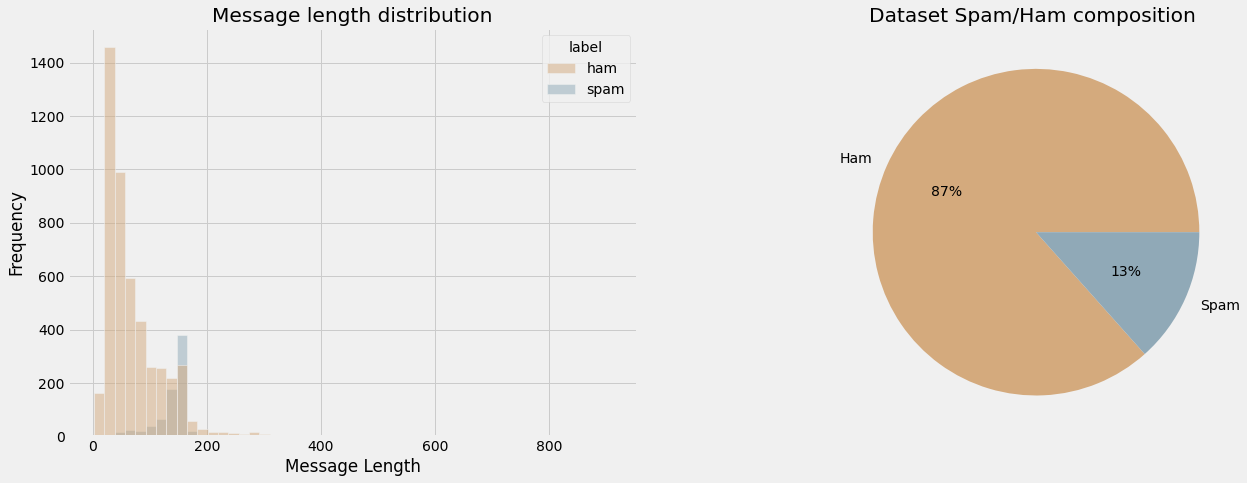

In [9]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))
sns.histplot(data=df, x="length",
             hue="label",
             bins=50,
             ax=ax[0],
             palette=['#D4AA7D',"#90A9B7"],
             legend=True).set_title('Message length distribution')
ax[0].set_xlabel('Message Length')
ax[0].set_ylabel('Frequency')

ax[1].pie(df.label.value_counts(normalize=True), 
            labels = ['Ham','Spam'], 
            autopct='%0.f%%', 
            colors=['#D4AA7D',"#90A9B7"]
            )
ax[1].set_title('Dataset Spam/Ham composition ')
plt.show()

In [10]:
nlp = en_core_web_sm.load()

In [11]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["message_clean"] = df["message"].apply(Clean)

#some combination of characters are still remaining from special characters' html tags 
df['message_clean'] = df['message_clean'].str.replace('lt gt', '')
df['message_clean'] = df['message_clean'].str.replace(' amp ', ' ')

#removing stop words
df["message_clean"] = df["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [12]:
df['length_clean']=df['message_clean'].apply(len)
df.head()

,label,message,length,message_clean,length_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,75
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...,103
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,19
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah don t think usf live,24


In [13]:
df[df.label=='ham'].describe()

,length,length_clean
count,4825.000000,4825.000000
mean,71.023627,36.185907
std,58.016023,31.214779
min,2.000000,0.000000
25%,33.000000,16.000000
50%,52.000000,27.000000
75%,92.000000,47.000000
max,910.000000,366.000000


In [14]:
df[df.label=='spam'].describe()

,length,length_clean
count,747.000000,747.000000
mean,138.866131,80.048193
std,29.183082,22.615929
min,13.000000,4.000000
25%,132.500000,69.000000
50%,149.000000,81.000000
75%,157.000000,96.000000
max,224.000000,134.000000


In [15]:
df[df.length == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [16]:
df[df.length == 910].message_clean.iloc[0]

'love start attraction feel need time thing come thought start day end time dream love breath life happen life cry happiness sorrow ready fight love crazy thing love don t proove girl beautiful lady planet singe praise love start chicken curry end makie sambar life beautiful morning thank god day like lot tell later'

In [17]:
df[df.length == 224].message.iloc[0]

'Good afternoon on this glorious anniversary day, my sweet J !! I hope this finds you happy and content, my Prey. I think of you and send a teasing kiss from across the sea coaxing images of fond souveniers ... You Cougar-Pen'

In [18]:
df[df.length == 224].message_clean.iloc[0]

'good afternoon glorious anniversary day sweet j hope find happy content prey think send teasing kiss sea coax image fond souvenier cougar pen'

In [19]:
df_ham  = df[df['label'] == 'ham'].copy()
df_spam = df[df['label'] == 'spam'].copy()

In [20]:
from wordcloud import WordCloud

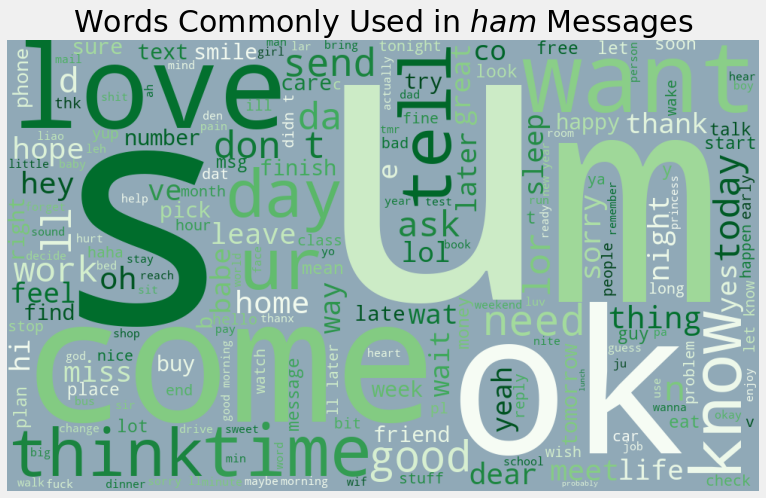

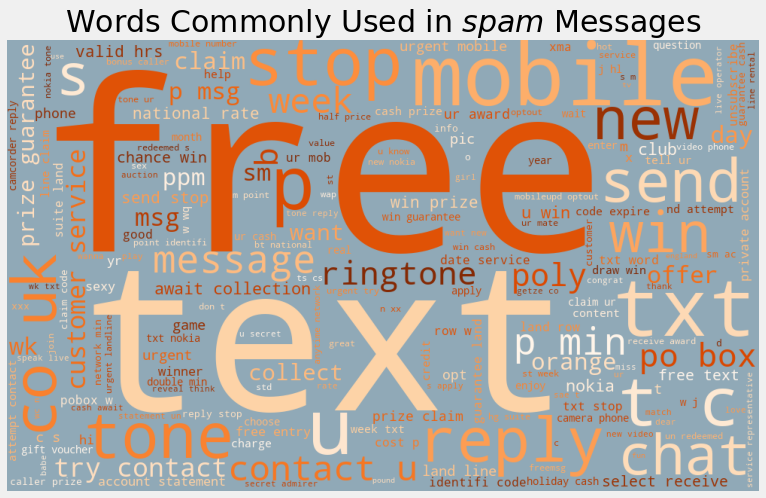

In [21]:
for label, cmap in zip(["ham", "spam"], ["Greens","Oranges"]):
    text = df.query("label == @label")["message_clean"].str.cat(sep=" ")
    plt.figure(figsize=(12, 8))
    wc = WordCloud(width=1000, height=600, background_color="#90A9B7", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=30)
    plt.show()

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" alt="Precision & Recall"/>
</p>



## What is the problem here?
we have an imbalanced dataset, most of our data points have the label of ham, and it is natural. becuase most of sms are ham. in this cases, accuracy can't be a good metric. we need to see other metrics.

## But what metric is better option?
in this probelm, false negetive and false positive are important. the metrics that give us the power of calcuating them are precision and recall, but there is one metric more, `f1-score`

## Why f1-score?
f1-score is the harmonic mean of precision and recall, so with one shot we can both two.

f1-score formula: $F_1 = 2 \times \frac{precision \times recall}{precision + recall}$

In spam detection tasks, the F1-score is often considered the best metric to use because it is a balance between precision and recall.

Precision is the number of true positive predictions divided by the total number of true positive and false positive predictions. It measures how many of the positive predictions made by the model are actually correct. High precision means that the model has a low number of false positives.

Recall is the number of true positive predictions divided by the total number of true positive and false negative predictions. It measures how many of the actual positive observations the model is able to identify. High recall means that the model has a low number of false negatives.

While precision and recall are both important in a spam detection task, they can be in conflict with each other, a model that maximizes precision might have low recall and vice versa. The F1-score, which is the harmonic mean of precision and recall, can be used to balance these two metrics and provide a more complete picture of the model's performance.

In spam detection, false negatives (i.e. actual spam messages which are classified as non-spam) are usually more critical than false positives (i.e. non-spam messages which are classified as spam), because it's more critical to block spam messages than to not block non-spam messages. The F1-score is better at balancing these two types of errors, it takes into account both the false negatives and false positives, which makes it a good metric to use in this task.

---

In [22]:
for token in nlp(df['message_clean'][0]) : 
  print(token.lemma_) 

jurong
point
crazy
available
bugis
n
great
world
la
e
buffet
cine
amore
wat


In [23]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(df.message_clean)

df["message_enc"] = tokenizer.texts_to_sequences(df.message_clean)
df["category"] = df["label"].apply(lambda x: 1 if x=="spam" else 0)
df.head()

,label,message,length,message_clean,length_clean,message_enc,category
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,75,"[1, 251, 460, 432, 960, 28, 56, 204, 721, 76, ...",0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23,"[8, 215, 1, 305, 2, 1]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...,103,"[11, 297, 541, 627, 25, 1, 786, 433, 1, 129, 1...",1
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,19,"[2, 130, 161, 1, 2, 50]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah don t think usf live,24,"[722, 31, 5, 21, 668, 137]",0


In [24]:
message_pad = tf.keras.preprocessing.sequence.pad_sequences(df.message_enc, padding="post")

In [25]:
xtrain, xval, ytrain, yval = train_test_split(message_pad,df.category, test_size=0.2)

train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [26]:
for sms, categ in train_batch.take(1):
  print(sms, categ)

tf.Tensor(
[[476   1   5 ...   0   0   0]
 [  1 222 303 ...   0   0   0]
 [ 42   4   1 ...   0   0   0]
 ...
 [ 99   2 735 ...   0   0   0]
 [ 64 155 325 ...   0   0   0]
 [  3  10   1 ...   0   0   0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0], shape=(64,), dtype=int64)


---

#Establishing a baseline

Let's look at some implementations of classic classification algorithms and how they fare with SMS Spam detection. 

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [28]:
lr = LogisticRegression(max_iter=1500)
lr.fit(xtrain,ytrain)
pred_logreg = lr.predict(xval)

print(classification_report(yval,pred_logreg))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       978
           1       0.53      0.23      0.32       137

    accuracy                           0.88      1115
   macro avg       0.72      0.60      0.63      1115
weighted avg       0.85      0.88      0.86      1115



In [29]:
nb = MultinomialNB()
nb.fit(xtrain,ytrain)
pred_nb = nb.predict(xval)

print(classification_report(yval,pred_nb))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       978
           1       0.35      0.52      0.42       137

    accuracy                           0.82      1115
   macro avg       0.64      0.69      0.66      1115
weighted avg       0.86      0.82      0.84      1115



## Pros:

- It's a simple and interpretable algorithm, meaning that it's easy to understand how the model is making its predictions.
- It's easy to train and efficient to predict with.
- It can handle non-linearly separable data using regularization.
- It's robust to irrelevant features.

## Cons:

- It assumes that the input features are independent, which may not be the case in text classification.
- It can be sensitive to the scale of the input features.
- It can have poor performance when the dataset is small or when the features are correlated.

In general, logistic regression and multinomial naive bayes are simple and interpretable models that can work well for text classification tasks. However, for more complex datasets and tasks, more sophisticated models like BERT may be needed to achieve better performance.

---

# Embedding model

The model is constructed as a sequential model with 4 layers:

- Embedding layer (tf.keras.layers.Embedding): This layer converts the input text into a dense numerical representation that can be input to the neural network. The input shape is set to the shape of the SMS dataset and the output dimension is 128.

- GlobalMaxPooling1D layer (tf.keras.layers.GlobalMaxPooling1D): This layer applies a max pooling operation to the output of the embedding layer, it's used to reduce the dimensionality of the input by only keeping the maximum values of each feature map.

- Dense layer (tf.keras.layers.Dense) with 16 neurons and a ReLU activation function: This layer is added on top of the pooled_output to adapt the pre-trained model to the new task.

- Dense layer (tf.keras.layers.Dense) with 1 neuron and a sigmoid activation function : It produces a single output value between 0 and 1, which can be interpreted as the probability of the input text belonging to the positive class (i.e., spam).

In [30]:
vocab_size = tokenizer.num_words

In [31]:
model_1 = tf.keras.Sequential([
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[sms.shape[1]],name="embedding"),
                  tf.keras.layers.GlobalMaxPooling1D(),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")
                            ])

this model is a simple neural network with an Embedding layer, a GlobalMaxPooling1D layer, a Dense layer with 16 neurons and a ReLU activation function, and a final Dense layer with a sigmoid activation function, is also a good model for text classification, including spam detection.

In [32]:
optimizer= tf.keras.optimizers.Adam()

model_1.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy
              ()])

binary cross-entropy will be used as the loss function because it is a common loss function for binary classification problems, where the goal is to predict one of two possible classes (in this case, spam or not spam).

The binary cross-entropy loss is calculated as the negative log-likelihood of the true labels given the predicted probabilities. The model is trained to minimize this loss.

The binary cross-entropy loss function is a measure of how well the predicted probabilities match the true labels. The predicted probability of a message being spam is a value between 0 and 1, and the true label is either 0 or 1.

The binary cross-entropy loss function penalizes the model heavily when the predicted probability is close to 0 or 1, but the true label is different. This is important for spam detection because it is crucial for the model to be confident in its predictions.

The binary cross-entropy loss function also gives more weight to examples that are misclassified. This is important in spam detection, as it is more important to correctly classify spam messages than non-spam messages.

In [33]:
history_1 = model_1.fit(train_batch, epochs=30, validation_data=val_batch, batch_size=64)

Epoch 1/30
70/70 [==============================] - 15s 152ms/step - loss: 0.5709 - binary_accuracy: 0.8308 - val_loss: 0.4144 - val_binary_accuracy: 0.8771
Epoch 2/30
70/70 [==============================] - 3s 50ms/step - loss: 0.3626 - binary_accuracy: 0.8631 - val_loss: 0.2746 - val_binary_accuracy: 0.8771
Epoch 3/30
70/70 [==============================] - 2s 34ms/step - loss: 0.1925 - binary_accuracy: 0.9221 - val_loss: 0.1112 - val_binary_accuracy: 0.9794
Epoch 4/30
70/70 [==============================] - 2s 30ms/step - loss: 0.0779 - binary_accuracy: 0.9821 - val_loss: 0.0600 - val_binary_accuracy: 0.9892
Epoch 5/30
70/70 [==============================] - 2s 35ms/step - loss: 0.0443 - binary_accuracy: 0.9881 - val_loss: 0.0465 - val_binary_accuracy: 0.9910
Epoch 6/30
70/70 [==============================] - 1s 12ms/step - loss: 0.0301 - binary_accuracy: 0.9919 - val_loss: 0.0414 - val_binary_accuracy: 0.9910
Epoch 7/30
70/70 [==============================] - 0s 7ms/step - lo

In [34]:
#setting a color chart for the seaborn plots
color_chart = ["#D4AA7D", "#EFD09E", "#90A9B7", "#D2D8B3"]

#Plotting loss and accuracy over epochs
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_1.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                          color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_1.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          )),
                      go.Scatter(
                          y=history_1.history["binary_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[2]
                          )),
                      go.Scatter(
                          y=history_1.history["val_binary_accuracy"],
                          name="Validation accruracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[3]
                          ))
                      ])
fig.update_layout(
                  title='Training and val loss across epochs (Embedding Model)',
                  xaxis_title='epochs',
                  yaxis_title='Cross Entropy'    
                  )
fig.show()

In [35]:
# Use the model to predict whether a message is spam
reviews = [
          'Hey, are you comming univarsity tomorrow?',
          'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
          'Good but you can do better',
          'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
          'Life sucks but you can make it beautiful',
          'Congrats,You won $1000 now give this money to poor people',
          'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
          "Why don't you wait 'til at least wednesday to see if you get your ."
          ]


# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=sms.shape[1])           

fakes_prediction = model_1.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(reviews)):
  print(reviews[x])
  print(fakes_prediction[x])
  print('\n')

1/1 [==============================] - 0s 83ms/step
Hey, are you comming univarsity tomorrow?
[3.4395096e-05]


Enter a chance to win $5000, hurry up, offer valid until march 31, 2021
[0.8966499]


Good but you can do better
[0.00037724]


You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99
[0.9999802]


Life sucks but you can make it beautiful
[0.00010474]


Congrats,You won $1000 now give this money to poor people
[6.926172e-05]


it to 80488. Your 500 free text messages are valid until 31 December 2005.
[0.9996008]


Why don't you wait 'til at least wednesday to see if you get your .
[0.00106149]




In [36]:
preds = model_1.predict(xval)
preds = preds.reshape(-1)
results_1 = pd.DataFrame({'test':yval,'pred':preds})
results_1['pred'] = round(results_1['pred'])
print(classification_report(results_1.test,results_1.pred))

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       978
           1       1.00      0.93      0.97       137

    accuracy                           0.99      1115
   macro avg       1.00      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



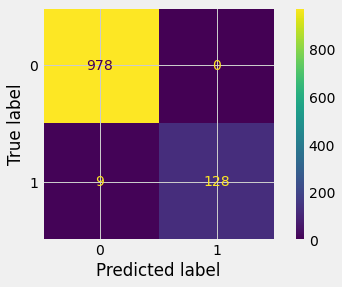

In [37]:
cm_test = confusion_matrix(results_1.test,results_1.pred)
ConfusionMatrixDisplay(cm_test).plot()
plt.show()

# Transfer Learning : BERT Model

BERT (Bidirectional Encoder Representations from Transformers) is a bi-directional model. It is designed to take into account the context both to the left and to the right of each word in the input text.

In traditional language models, the model only takes into account the context to the left of each word, this is known as left-to-right (or "unidirectional") models. BERT, instead, takes into account both the context to the left and to the right of each word, this is known as bidirectional models.

This allows BERT to better understand the meaning and context of each word in the input text, which is important for natural language understanding tasks such as text classification

In [38]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [39]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocessor(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model_tlbert = tf.keras.Model(inputs=[text_input], outputs = [l])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


This model is a text classification model that uses transfer learning to fine-tune a pre-trained BERT model for the task of spam detection.

- The model starts by loading a preprocessor from TensorFlow Hub, which is used to clean and tokenize the input text. This preprocessor is a version of the BERT model that has been trained to perform text preprocessing tasks such as tokenization and lowercasing.

- The preprocessed text is then passed to the BERT encoder, which is a pre-trained transformer model that has been trained on a large amount of text data. The BERT encoder is able to understand the meaning and context of the text and is able to extract features from the text that are relevant to the classification task.

- The outputs of the BERT encoder are then passed through a dropout layer and a dense layer with a sigmoid activation function. The dropout layer randomly sets a fraction of the input units to 0 during training, which helps to prevent overfitting. The dense layer with sigmoid activation function produces a single output value between 0 and 1, which can be interpreted as the probability of the input text belonging to the positive class (i.e., spam).

- The final model is then constructed using the input and output layers. 

The model is then fine-tuned on a labeled dataset of SMS messages, where the labels indicate whether a message is spam or not, the model learns to identify patterns and features in the text that are indicative of spam messages. Once the model is trained, we'll use it to classify new, unseen SMS messages as spam or not spam based on their text.

In [40]:
model_tlbert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [41]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

model_tlbert.compile(optimizer ='adam',
                      loss = 'binary_crossentropy',
                      metrics = Metrics)

In [42]:
# Train test split per text 
text_train, text_test, y_train, y_test = train_test_split(df.message_clean, df.category, test_size=0.2, random_state=1,stratify=df.category)
text_train, text_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.2, random_state=1,stratify=y_train)

# creating tensorflow datasets slices and making batches
text_train_ds = tf.data.Dataset.from_tensor_slices((text_train, y_train))
text_test_ds = tf.data.Dataset.from_tensor_slices((text_test, y_test))
text_val_ds = tf.data.Dataset.from_tensor_slices((text_val, y_val))

text_train_ds = text_train_ds.shuffle(len(text_train_ds)).batch(64)
text_test_ds = text_test_ds.shuffle(len(text_test_ds)).batch(64)
text_val_ds = text_val_ds.shuffle(len(text_val_ds)).batch(64)

In [43]:
history_tlbert = model_tlbert.fit(text_train_ds, epochs=30, validation_data=text_val_ds)

Epoch 1/30
56/56 [==============================] - 24s 239ms/step - loss: 0.3561 - accuracy: 0.8511 - precision: 0.2946 - recall: 0.0795 - val_loss: 0.2900 - val_accuracy: 0.8688 - val_precision: 0.6667 - val_recall: 0.0500
Epoch 2/30
56/56 [==============================] - 12s 222ms/step - loss: 0.2982 - accuracy: 0.8715 - precision: 0.5877 - recall: 0.1402 - val_loss: 0.2694 - val_accuracy: 0.8733 - val_precision: 0.6522 - val_recall: 0.1250
Epoch 3/30
56/56 [==============================] - 12s 222ms/step - loss: 0.2825 - accuracy: 0.8799 - precision: 0.6645 - recall: 0.2113 - val_loss: 0.2530 - val_accuracy: 0.8823 - val_precision: 0.7419 - val_recall: 0.1917
Epoch 4/30
56/56 [==============================] - 12s 224ms/step - loss: 0.2678 - accuracy: 0.8895 - precision: 0.7658 - recall: 0.2531 - val_loss: 0.2395 - val_accuracy: 0.9002 - val_precision: 0.7925 - val_recall: 0.3500
Epoch 5/30
56/56 [==============================] - 12s 221ms/step - loss: 0.2512 - accuracy: 0.8968

In [44]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 13 05:23:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    80W / 400W |   1988MiB / 40536MiB |     53%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_tlbert.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                          color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_tlbert.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          )),
                      go.Scatter(
                          y=history_tlbert.history["accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[2]
                          )),
                      go.Scatter(
                          y=history_tlbert.history["val_accuracy"],
                          name="Validation accruracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[3]
                          ))
                      ])
fig.update_layout(
                  title='Training and val loss across epochs (BERT Model)',
                  xaxis_title='epochs',
                  yaxis_title='Cross Entropy'    
                  )
fig.show()

In [46]:
preds = model_tlbert.predict(text_val)
preds = preds.reshape(-1)
results_tlbert = pd.DataFrame({'test':y_val,'pred':preds})
results_tlbert['pred'] = round(results_tlbert['pred'])
print(classification_report(results_tlbert.test,results_tlbert.pred))

28/28 [==============================] - 3s 64ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       772
           1       0.96      0.73      0.83       120

    accuracy                           0.96       892
   macro avg       0.96      0.86      0.90       892
weighted avg       0.96      0.96      0.96       892



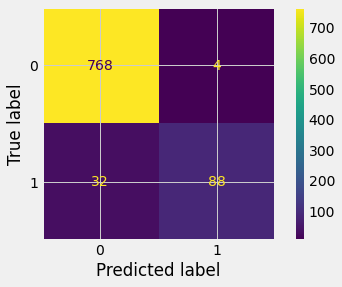

In [47]:
cm_test = confusion_matrix(results_tlbert.test,results_tlbert.pred)
ConfusionMatrixDisplay(cm_test).plot()
plt.show()

In [48]:
result_bert = model_tlbert.predict(reviews)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(reviews)):
  print(reviews[x])
  print(result_bert[x])
  print('\n')

1/1 [==============================] - 1s 863ms/step
Hey, are you comming univarsity tomorrow?
[0.06337517]


Enter a chance to win $5000, hurry up, offer valid until march 31, 2021
[0.36872324]


Good but you can do better
[0.01055648]


You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99
[0.58312356]


Life sucks but you can make it beautiful
[0.01297737]


Congrats,You won $1000 now give this money to poor people
[0.13760088]


it to 80488. Your 500 free text messages are valid until 31 December 2005.
[0.42772868]


Why don't you wait 'til at least wednesday to see if you get your .
[0.01583266]




---

## Performance Benchmark
Let's compare the different models' performances by looking at the accuracy and F1-score

In [49]:
def performance_model(model, X, y):

    y_pred = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
  
    model_performance = {'accuracy': accuracy,
                          'f1-score': f1,
                         'precision': precision,
                         'recall' : recall}
  
    return model_performance

In [50]:
logreg = performance_model(lr, xval, yval)
naiveb = performance_model(nb, xval, yval)
simple_model = performance_model(model_1,xval, yval)
BERT_model = performance_model(model_tlbert,text_val, y_val)
  
data_results = pd.DataFrame({'Logistic Regression':logreg,
                             'Multinomial Naive Bayes':naiveb,
                             'Sequential Simple Model':simple_model,
                             'BERT-Transfer learning Model':BERT_model,}).transpose().sort_values(by='f1-score',ascending=False)
                             
data_results.iloc[:,:4]

28/28 [==============================] - 2s 69ms/step


,accuracy,f1-score,precision,recall
Sequential Simple Model,0.991928,0.966038,1.000000,0.934307
BERT-Transfer learning Model,0.959641,0.830189,0.956522,0.733333
Multinomial Naive Bayes,0.822422,0.417647,0.349754,0.518248
Logistic Regression,0.880717,0.317949,0.534483,0.226277


There could be several reasons why a model with a simple embedding layer performed better than other models in our spam detection task. Some possible reasons include:

- The dataset: Depending on the size and quality of the dataset used for training, some models may perform better than others. For example, if the dataset is small, simpler models like the one with an embedding layer may be able to achieve good performance without the need for more complex architectures like BERT.

- The features: The embedding layer can help to represent the text in a more meaningful way, by mapping words to a dense numerical representation that captures their semantic meaning. This can be more effective than using the raw text as input, especially if the dataset is small.

- Overfitting: With more complex models like BERT, there is a risk of overfitting, which occurs when a model performs well on the training data but poorly on the test data. The Embedding layer model with max pooling layer and a dense layer can be less prone to overfitting than more complex models like BERT.

- Fine-tuning: The pre-trained BERT model was trained on a large corpus of text, but it may not be as effective when fine-tuned on a specific dataset. The Embedding layer model can be fine-tuned better on the specific dataset.

- Hyperparameters: Different models have different hyperparameters that can be adjusted to improve performance. The Embedding layer model may have performed better because the specific hyperparameters used were better suited to the dataset and task at hand.